# Predicting Credit Card Default

**Goal: to predict if a customer will default the credite card payment**

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from collections import OrderedDict
import time
from sklearn.pipeline import make_pipeline, Pipeline
import os
import pickle

### Reading file

In [137]:
default = pd.read_csv(".\\data\\credit_card_default.csv", index_col = "ID")
default.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,defaulted
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Data Preparation

In [138]:
default.rename(columns = lambda x: x.lower(), inplace = True)
default["male"] = (default["sex"] == 1).astype(int)
default["married"] = (default["marriage"] == 1).astype(int)
default["grad_school"] = (default["education"] == 1).astype(int)
default["university"] = (default["education"] == 2).astype(int)
default["high_school"] = (default["education"] == 3).astype(int)
default.drop(["male", "married", "education"], axis = 1, inplace = True)
default.rename(columns = {"defaulted": "default"}, inplace = True)

In [139]:
pay = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
for x in pay:
    default.loc[default[x] <= 0, x] = 0

In [5]:
default.head()

,limit_bal,sex,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,...,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default,grad_school,university,high_school
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,1,24,2,2,0,0,0,0,...,0,689,0,0,0,0,1,0,1,0
2,120000,2,2,26,0,2,0,0,0,2,...,0,1000,1000,1000,0,2000,1,0,1,0
3,90000,2,2,34,0,0,0,0,0,0,...,1518,1500,1000,1000,1000,5000,0,0,1,0
4,50000,2,1,37,0,0,0,0,0,0,...,2000,2019,1200,1100,1069,1000,0,0,1,0
5,50000,1,1,57,0,0,0,0,0,0,...,2000,36681,10000,9000,689,679,0,0,1,0


## Building models

### Utils:  

1. To create a DataFrame for comparision of models

In [7]:
def make_comparision_df(index_lst:[str], columns_lst:[str]):
    comparision_df = pd.DataFrame(index = index_lst, columns = columns_lst)
    return comparision_df

2. To create Confusion Matrix

In [8]:
def printMatrix(CM, labels = ["pay", "default"]):
    df = pd.DataFrame(CM, index = labels, columns = labels)
    df.index.name = "True"
    df.columns.name = "Prediction"
    df["Total"] = df.sum(axis = 1)
    df.loc["Total"] = df.sum()
    return df

3. The prediction analysis function

In [9]:
def analyze_prediction(y_predicted, y_observed, result_matrix = None, model_name = None):
    accuracy = accuracy_score(y_pred = y_predicted, y_true = y_observed)
    precision = precision_score(y_pred = y_predicted, y_true = y_observed)
    recall = recall_score(y_pred = y_predicted, y_true = y_observed)
    
    if (model_name != None):
        result_matrix.loc["accuracy", model_name] = 100 * accuracy
        result_matrix.loc["precision", model_name] = 100 * precision
        result_matrix.loc["recall", model_name] = 100 * recall
    print("Accuracy, Precision, Recall")
    return accuracy, precision, recall

4. A function to adjust the threshold

In [10]:
def adjust_threshold(probability, threshold, y_observed):
    y_pred_original = (probability >= 0.5).astype(int)
    recall_original = 100 * recall_score(y_pred = y_pred_original, y_true = y_observed)
    precision_original = 100 * precision_score(y_pred = y_pred_original, y_true = y_observed)
    
    y_pred_new = (probability >= 0.2).astype(int)
    recall_new = 100 * recall_score(y_pred = y_pred_new, y_true = y_observed)
    precision_new = 100 * precision_score(y_pred = y_pred_new, y_true = y_observed)
    
    comparision_df = pd.DataFrame({"Threshold = 0.5": [recall_original, precision_original],
                                  "Threshold = 0.2": [recall_new, precision_new]},
                                  index = ["Recall", "Precision"])
    CM = confusion_matrix(y_pred_new, y_observed)
    confusion_df = printMatrix(CM)
    return comparision_df, confusion_df

5. A function to make the finall prediction

In [11]:
def make_predict(new_data, model, scaler, threshold):
    data = new_data.values.reshape(1, -1)
    data = scaler.transform(data)
    prob = model.predict_proba(data)[0, 1]
    if prob >= threshold:
        return "Will Default"
    else:
        return "Will Pay"

6. A function to plot 2 lines in one figure

In [12]:
def plot_2lines(x1, y1, x2, y2, c1 = "red", c2 = "blue", lbl1 = "func1", lbl2 = "func2", xlbl = "x_axis", ylbl = "y_axis", title = "Title", grid = True):
    fix, ax = plt.subplots(figsize = (8, 4))
    ax.plot(x1, y1, color = c1, label = lbl1)
    ax.plot(x2, y2, color = c2, label = lbl2)
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    ax.set_title(title)
    ax.legend(loc = "upper right")
    if (grid == True):
        ax.grid

7. A function to create bar plots

In [13]:
def make_bar_plot(X, y, title = 'Title', xlbl = 'X_Label', ylbl = 'Y_Label',
                  xRotation = 90, annotation = False):
    fig, ax = plt.subplots(figsize = (8, 4))
    sns.barplot(X, y, ax = ax)
    patches = ax.patches
    n = len(patches)
    if(n == 2):
        patches[0].set_facecolor('cornflowerblue')
        patches[1].set_facecolor('orangered')
    else:
        for i in range(n):
            x = (n-1)/n - i/n
            patches[i].set_facecolor(plt.cm.brg(x))
            
    if(annotation == True):
        for p in ax.patches:
            x = p.get_bbox().get_points()[:,0]
            y = p.get_bbox().get_points()[1,1]
            ax.annotate('{:.1f}%'.format(y), (x.mean(), y), ha = 'center', va = 'bottom')

    if(xRotation != 0):
        ax.tick_params(axis = 'x', labelrotation = xRotation)

    ax.set_title(title, fontweight = "bold")
    ax.set_xlabel(xlbl, fontweight = "bold")
    ax.set_ylabel(ylbl, fontweight = "bold")

8. A function to evaluate the effect of data size on the predictability

In [14]:
def analyze_data_size(keep_ratio,X_train_original, X_test_original, y_train_original, y_test_original):
    X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_train_original,
                                                                        y_train_original,
                                                                        train_size = keep_ratio,
                                                                        random_state = 123, 
                                                                        stratify = y_train_original)
        
    NB = GaussianNB(var_smoothing = 0.1873817422860384)
    NB.fit(X_train_new, y_train_new)
    y_pred_test = NB.predict(X_test_original)
    analyze_prediction(y_pred_test, y_test_original, result_matrix = models_dataSize, model_name =
                                                                     str(round(100 * keep_ratio))+"%")

### Scalling and splitting the dataset

In [140]:
target_name = "default"
X = default.drop(target_name, axis = 1)
X_columns = X.columns            # We will use the columns names for future plotting.
y = default[target_name]
RS = RobustScaler()
X = RS.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 123, stratify = y)

#### Creating a table to compare the models

In [16]:
models = make_comparision_df(index_lst = ["accuracy", "precision", "recall"],
                             columns_lst = ["NULL", "LogisticReg", "ClassTree", "NaiveBayes"])
models

,NULL,LogisticReg,ClassTree,NaiveBayes
accuracy,NaN,NaN,NaN,NaN
precision,NaN,NaN,NaN,NaN
recall,NaN,NaN,NaN,NaN


In [17]:
print(y_train.size)
print(y_train.value_counts())

25500
0    19859
1     5641
Name: default, dtype: int64


### A. NULL Model

In [18]:
y_pred_test = [0] * y_test.size
print(y_pred_test[:10])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [19]:
analyze_prediction(y_pred_test, y_test, result_matrix = models, model_name = "NULL")

Accuracy, Precision, Recall


C:\Users\tohid\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.7788888888888889, 0.0, 0.0)

In [20]:
models

,NULL,LogisticReg,ClassTree,NaiveBayes
accuracy,77.888889,NaN,NaN,NaN
precision,0.0,NaN,NaN,NaN
recall,0.0,NaN,NaN,NaN


In [21]:
CM = confusion_matrix(y_pred = y_pred_test, y_true = y_test)
printMatrix(CM)

Prediction,pay,default,Total
True,,,
pay,3505,0,3505
default,995,0,995
Total,4500,0,4500


### B. Logistic Regression Model

In [22]:
LR = LogisticRegression(n_jobs = -1, random_state = 123)
LR.fit(X_train, y_train)
y_pred_test = LR.predict(X_test)
analyze_prediction(y_pred_test, y_test, result_matrix = models, model_name = "LogisticReg")

Accuracy, Precision, Recall


(0.8193333333333334, 0.6978260869565217, 0.32261306532663314)

In [23]:
CM = confusion_matrix(y_pred = y_pred_test, y_true = y_test)
printMatrix(CM)

Prediction,pay,default,Total
True,,,
pay,3366,139,3505
default,674,321,995
Total,4040,460,4500


### C. Decision Tree Model

In [24]:
DTC = DecisionTreeClassifier(min_samples_split = 30, min_samples_leaf = 10, random_state = 123)
DTC.fit(X_train, y_train)
y_pred_test = DTC.predict(X_test)
analyze_prediction(y_pred_test, y_test, result_matrix = models, model_name = "ClassTree")

Accuracy, Precision, Recall


(0.7886666666666666, 0.5321637426900585, 0.3658291457286432)

In [25]:
CM = confusion_matrix(y_pred = y_pred_test, y_true = y_test)
printMatrix(CM)

Prediction,pay,default,Total
True,,,
pay,3185,320,3505
default,631,364,995
Total,3816,684,4500


### D. Naive Bayes Model

In [26]:
NB = GaussianNB()
NB.fit(X_train, y_train)
y_pred_test = NB.predict(X_test)
analyze_prediction(y_pred_test, y_test, result_matrix = models, model_name = "NaiveBayes")

Accuracy, Precision, Recall


(0.7704444444444445, 0.4834494773519164, 0.5577889447236181)

In [27]:
CM = confusion_matrix(y_pred = y_pred_test, y_true = y_test)
printMatrix(CM)

Prediction,pay,default,Total
True,,,
pay,2912,593,3505
default,440,555,995
Total,3352,1148,4500


#### In the present case:

**Accuracy**:  means overall how often the model predicts correctly defaulters and non-defaulters.

**Precision**: means when the model predicts default how often it's correct. 

**Recall**:    means the proportion of actual defaulters that the model will correctly predict.

Which metrics should we use depends on which mistake we want to avoid.

So in this context:

**False positive**: is a person who will pay and is predicted by the model as a defaulter.

**False negative**: is a person who will default and is predicted as a payer, as somebody who will pay.

In this case, the **False negatives** are **worse**. So if we want to avoid false negatives we should go for the **recall** as our main metric to evaluate the performance of the model.

### Plot and compare the models

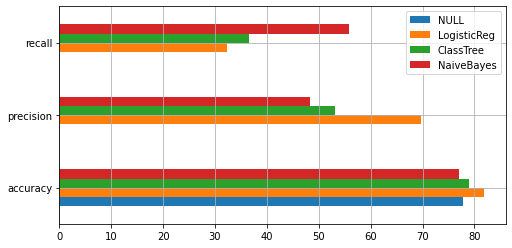

In [28]:
fig, ax = plt.subplots(figsize = (8, 4))
models.plot(kind = "barh", ax = ax)
ax.grid()

#### Insight:
As can be seen, Naive Bayes model yeilds the highest recall while Logistic Regression model has the highest precision.

### Recall, Precision, and Threshold

Let's evaluate the relationship between recall, precision, and threshold for the Naive Bayes and Logistic Regression models.

In [29]:
precision_NB, recall_NB, threshold_NB = precision_recall_curve(y_true = y_test, 
                                                                  probas_pred = NB.predict_proba(X_test)[:,1])
precision_LR, recall_LR, threshold_LR = precision_recall_curve(y_true = y_test, 
                                                                  probas_pred = LR.predict_proba(X_test)[:,1])

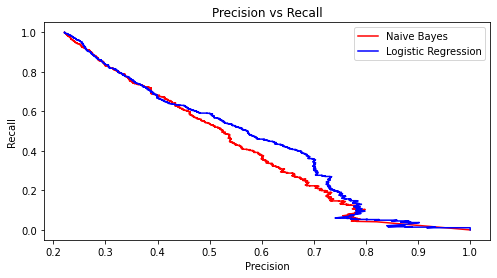

In [30]:
plot_2lines(x1 = precision_NB, y1 = recall_NB, 
            x2 = precision_LR, y2 = recall_LR, 
            lbl1 = "Naive Bayes", lbl2 = "Logistic Regression",
            xlbl = "Precision", ylbl = "Recall", title = "Precision vs Recall")

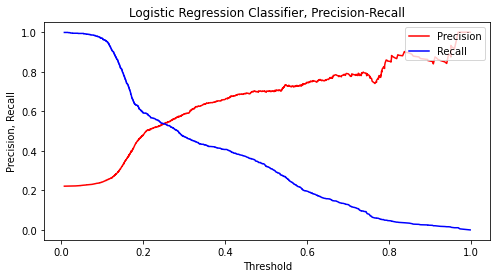

In [31]:
plot_2lines(x1 = threshold_LR, y1 = precision_LR[1:],
            x2 = threshold_LR, y2 = recall_LR[1:], 
            lbl1 = "Precision", lbl2 = "Recall",
            xlbl = "Threshold", ylbl = "Precision, Recall", 
            title = "Logistic Regression Classifier, Precision-Recall")

#### Insight:
Depending on the priority of bussiness metrics and other bussiness related factors, we can choose the models with the recall, precision, and trhreshold as desired.

### Adjusting the threshold

In [32]:
probability = LR.predict_proba(X_test)[:,1]
comparision_df, confusion_df = adjust_threshold(probability, 0.2, y_test)
comparision_df

,Threshold = 0.5,Threshold = 0.2
Recall,32.261307,59.296482
Precision,69.782609,48.084760


## To make a prediction

Now, let's retrain the best model with all the observed data, then use it to do prediction for a new costumer with a given set of input data.

The best model in this case is the Naive Bayes model and we prefer to try a threshold of 0.2 to make the prediction.

In [33]:
new_customer = OrderedDict([('limit_bal', 4000), ('age', 50), ('bill_amt1', 500),
                            ('bill_amt2', 35509), ('bill_amt3', 689), ('bill_amt4', 0),
                            ('bill_amt5',0), ('bill_amt6',0), ('pay_amt1', 0),('pay_amt2', 35509),
                            ('pay_amt3', 0), ('pay_amt4', 0),('pay_amt5',0), ('pay_amt6',0),
                            ('male', 1), ('married',1), ('grad_school', 0), ('university',1),
                            ('high_school',0), ('pay_0', -1),('pay_2', -1),
                            ('pay_3', -1), ('pay_4', 0),('pay_5',-1), ('pay_6',0)])
new_costomer = pd.Series(new_customer)

In [34]:
make_predict(new_costomer, model = NB, scaler = RS, threshold = 0.2)

'Will Default'

In [35]:
make_predict(new_costomer, model = LR, scaler = RS, threshold = 0.2)

'Will Default'

#### Conclusion:
The trained models predict that the new customer will default.

## Improving the predictability

### Try other models

#### Random Forest Model

In [37]:
RF = RandomForestClassifier(random_state = 123)
RF.fit(X_train, y_train)
y_pred_test = RF.predict(X_test)
analyze_prediction(y_pred_test, y_test, result_matrix = models, model_name = "RandomForest")

Accuracy, Precision, Recall


(0.8175555555555556, 0.6593406593406593, 0.36180904522613067)

#### XGBoost Model

In [38]:
XGB = XGBClassifier(random_state = 123, n_jobs = -1, eval_metric = 'logloss', verbosity = 0)
XGB.fit(X_train, y_train)
y_pred_test = XGB.predict(X_test)
analyze_prediction(y_pred_test, y_test, result_matrix = models, model_name = "XGBoost")

C:\Users\tohid\anaconda3\envs\myland\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy, Precision, Recall


(0.8175555555555556, 0.6605166051660517, 0.3597989949748744)

In [39]:
models

,NULL,LogisticReg,ClassTree,NaiveBayes,RandomForest,XGBoost
accuracy,77.888889,81.933333,78.866667,77.044444,81.755556,81.755556
precision,0.0,69.782609,53.216374,48.344948,65.934066,66.051661
recall,0.0,32.261307,36.582915,55.778894,36.180905,35.979899


# hyperparameter tunning

### Optimizing the parameters of Random Forest and XGBoost models

#### Optimization of Random Forest model

In [41]:
RF = RandomForestClassifier(random_state = 123)
cnt = int(default.shape[1]/2)
parameters = {'n_estimators':[50 , 100, 200],
              'min_samples_split': [2,5,10],
              'max_features': ['auto', cnt]}
clf = GridSearchCV(RF, parameters, cv = 5, scoring = "recall")
clf.fit(X_train, y_train)
clf.best_params_

{'max_features': 13, 'min_samples_split': 5, 'n_estimators': 50}

In [42]:
RFopt = RandomForestClassifier(max_features = 13, min_samples_split = 2, n_estimators = 200,
                            random_state = 123)

RFopt.fit(X_train, y_train)
y_pred_test = RFopt.predict(X_test)
analyze_prediction(y_pred_test, y_test, result_matrix = models, model_name = "RandomForest")

Accuracy, Precision, Recall


(0.816, 0.6504504504504505, 0.3628140703517588)

#### Optimization of XGBoost model

In [43]:
XGB = XGBClassifier(random_state = 123, n_jobs = -1, eval_metric = 'logloss', verbosity = 0)
parameters = {'n_estimators':[50 , 100, 200],
              'learning_rate': [0.05, 0.1, 0.3, 0.5]}
clf = GridSearchCV(XGB, parameters, cv = 5, scoring = "recall")
clf.fit(X_train, y_train)
clf.best_params_

C:\Users\tohid\anaconda3\envs\myland\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\tohid\anaconda3\envs\myland\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\tohid\anaconda3\envs\myland\lib\site-packages\xgboost\sklearn

C:\Users\tohid\anaconda3\envs\myland\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\tohid\anaconda3\envs\myland\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\tohid\anaconda3\envs\myland\lib\site-packages\xgboost\sklearn

C:\Users\tohid\anaconda3\envs\myland\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\tohid\anaconda3\envs\myland\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\tohid\anaconda3\envs\myland\lib\site-packages\xgboost\sklearn

C:\Users\tohid\anaconda3\envs\myland\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\tohid\anaconda3\envs\myland\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\tohid\anaconda3\envs\myland\lib\site-packages\xgboost\sklearn

{'learning_rate': 0.5, 'n_estimators': 50}

In [44]:
XGBopt = XGBClassifier(n_estimators = 50, learning_rate = 0.5, random_state = 123, n_jobs = -1,
                    eval_metric = 'logloss', verbosity = 0)

XGBopt.fit(X_train, y_train)
y_pred_test = XGBopt.predict(X_test)
analyze_prediction(y_pred_test, y_test, result_matrix = models, model_name = "XGBoost")

Accuracy, Precision, Recall


(0.8137777777777778, 0.637478108581436, 0.3658291457286432)

In [45]:
models

,NULL,LogisticReg,ClassTree,NaiveBayes,RandomForest,XGBoost
accuracy,77.888889,81.933333,78.866667,77.044444,81.600000,81.377778
precision,0.0,69.782609,53.216374,48.344948,65.045045,63.747811
recall,0.0,32.261307,36.582915,55.778894,36.281407,36.582915


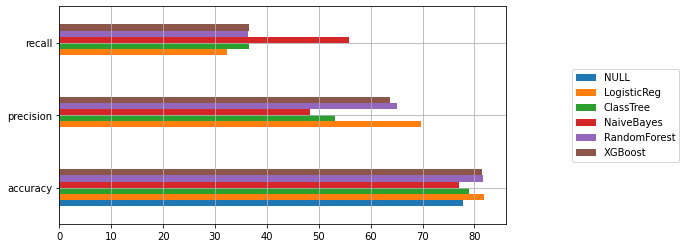

In [46]:
fig, ax = plt.subplots(figsize = (8, 4))
models.plot(kind = "barh", ax = ax)
ax.legend(loc = 'center right', bbox_to_anchor = (1.4, 0.5))
ax.grid()

#### Optimization of Naive Bayes model

##### Comparision table

In [55]:
optNBmodels = make_comparision_df(index_lst = ["accuracy", "precision", "recall"],
                             columns_lst = ["NBoptRecall", "NBoptAccuracy", "NBoptPrecision"])
optNBmodels

,NBoptRecall,NBoptAccuracy,NBoptPrecision
accuracy,NaN,NaN,NaN
precision,NaN,NaN,NaN
recall,NaN,NaN,NaN


#### Naive Bayes Model before optimization

In [62]:
NBmodels = make_comparision_df(index_lst = ["accuracy", "precision", "recall"],
                             columns_lst = ["NaiveBayes", "NBoptimized"])
NBmodels

,NaiveBayes,NBoptimized
accuracy,NaN,NaN
precision,NaN,NaN
recall,NaN,NaN


In [67]:
NB = GaussianNB()
NB.fit(X_train, y_train)
y_pred_test = NB.predict(X_test)
analyze_prediction(y_pred_test, y_test, result_matrix = NBmodels, model_name = "NaiveBayes")

Accuracy, Precision, Recall


(0.7704444444444445, 0.4834494773519164, 0.5577889447236181)

#### Optimizition based on recall

In [38]:
NB = GaussianNB()
parameters = {'var_smoothing': np.logspace(0, -9, num = 100)}
clf = GridSearchCV(NB, parameters, cv = 5, scoring = "recall")
clf.fit(X_train, y_train)
clf.best_params_

{'var_smoothing': 0.1873817422860384}

In [63]:
NBopt1 = GaussianNB(var_smoothing = 0.1873817422860384)
NBopt1.fit(X_train, y_train)
y_pred_test = NBopt1.predict(X_test)
analyze_prediction(y_pred_test, y_test, result_matrix = optNBmodels, model_name = "NBoptRecall")
analyze_prediction(y_pred_test, y_test, result_matrix = NBmodels, model_name = "NBoptimized")

Accuracy, Precision, Recall
Accuracy, Precision, Recall


(0.46155555555555555, 0.2751889168765743, 0.878391959798995)

#### Optimizition based on accuracy

In [40]:
NB = GaussianNB()
parameters = {'var_smoothing': np.logspace(0, -9, num = 100)}
clf = GridSearchCV(NB, parameters, cv = 5, scoring = "accuracy")
clf.fit(X_train, y_train)
clf.best_params_

{'var_smoothing': 0.657933224657568}

In [41]:
NBopt2 = GaussianNB(var_smoothing = 0.657933224657568)
NBopt2.fit(X_train, y_train)
y_pred_test = NBopt2.predict(X_test)
analyze_prediction(y_pred_test, y_test, result_matrix = optNBmodels, model_name = "NBoptAccuracy")

Accuracy, Precision, Recall


(0.798, 0.76875, 0.12361809045226131)

#### Optimizition based on precision

In [42]:
NB = GaussianNB()
parameters = {'var_smoothing': np.logspace(0, -9, num = 100)}
clf = GridSearchCV(NB, parameters, cv = 5, scoring = "precision")
clf.fit(X_train, y_train)
clf.best_params_

{'var_smoothing': 1.0}

In [43]:
NBopt3 = GaussianNB(var_smoothing = 1)
NBopt3.fit(X_train, y_train)
y_pred_test = NBopt3.predict(X_test)
analyze_prediction(y_pred_test, y_test, result_matrix = optNBmodels, model_name = "NBoptPrecision")

Accuracy, Precision, Recall


(0.78, 0.8571428571428571, 0.006030150753768844)

In [44]:
optNBmodels

,NBoptRecall,NBoptAccuracy,NBoptPrecision
accuracy,46.155556,79.8,78.0
precision,27.518892,76.875,85.714286
recall,87.839196,12.361809,0.603015


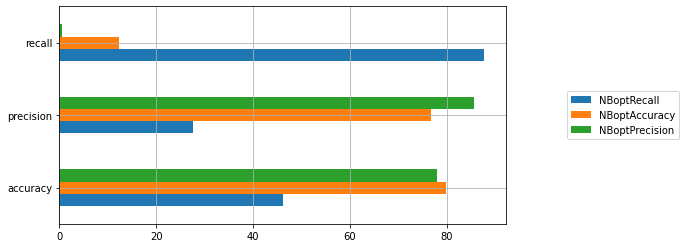

In [45]:
fig, ax = plt.subplots(figsize = (8, 4))
optNBmodels.plot(kind = "barh", ax = ax)
ax.legend(loc = 'center right', bbox_to_anchor = (1.4, 0.5))
ax.grid()

Text(0.5, 1.0, 'Optimized Models with different criteria')

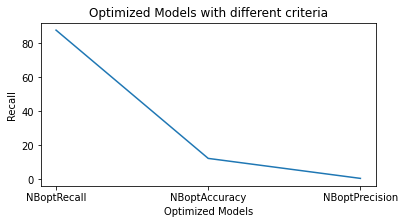

In [48]:
X_axis = ["NBoptRecall", "NBoptAccuracy", "NBoptPrecision"]
y_axis = optNBmodels.loc["recall"]
fix, ax = plt.subplots(figsize = (6, 3))
ax.plot(X_axis, y_axis)
ax.set_xlabel("Optimized Models")
ax.set_ylabel("Recall")
ax.set_title("Optimized Models with different criteria")

#### Insight:
As can be seen, we can select the optimization criteria to maximize the predictability depending on our bussiness metrics. 

It is obviouse that the recall for the Naive Bayes model which is optimized based on the recall yeilds much higher recall value than the other models.

In [68]:
NBmodels

,NaiveBayes,NBoptimized
accuracy,77.044444,46.155556
precision,48.344948,27.518892
recall,55.778894,87.839196


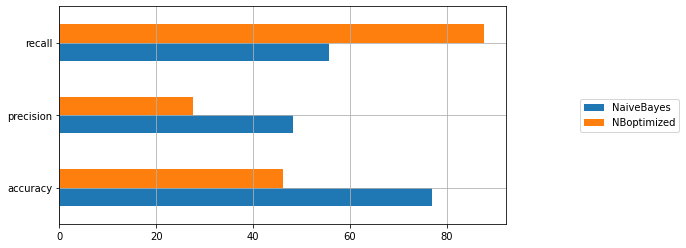

In [69]:
fig, ax = plt.subplots(figsize = (8, 4))
NBmodels.plot(kind = "barh", ax = ax)
ax.legend(loc = 'center right', bbox_to_anchor = (1.4, 0.5))
ax.grid()

Text(0.5, 1.0, 'Recall of NB models before and after optimization')

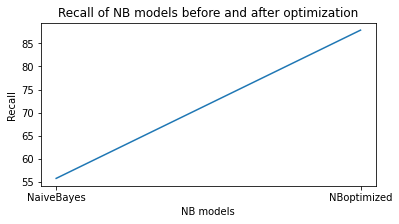

In [71]:
X_axis = ["NaiveBayes", "NBoptimized"]
y_axis = NBmodels.loc["recall"]
fix, ax = plt.subplots(figsize = (6, 3))
ax.plot(X_axis, y_axis)
ax.set_xlabel("NB models")
ax.set_ylabel("Recall")
ax.set_title("Recall of NB models before and after optimization")

#### Insight:
So, the recall has improved significantly by optimizing the Naive Bayse model.

## Finding the importance of each feature using Random Forest Model

### Feature importance
- models like RF and XGB after fitting a model, they can give us the importance and effectiveness of each feature
- we can plot them and see if we want to do feature engineering and add a new feature, or dropping some features ...

C:\Users\tohid\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


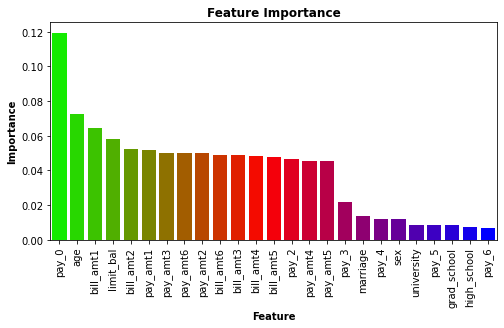

In [73]:
RF = RandomForestClassifier(max_features = 13, min_samples_split = 2, 
                            n_estimators = 200, random_state = 123)
RF.fit(X_train, y_train)
imp_values = list(RF.feature_importances_)
imp_table = pd.DataFrame({'feature':list(X_columns), 'importance':imp_values})
imp_table.sort_values(by ='importance',inplace = True, ascending = False)
make_bar_plot(X = imp_table['feature'], y = imp_table['importance'],
              title = 'Feature Importance', xlbl = 'Feature', ylbl = 'Importance')

#### Insight: 
We can see the importance of each parameter in the model. We can use this result to evaluate what happens if we disregard the least important features to decrease the calculation time and the hardware needed while improving the model's predictability or loss an ignorable amount of prediction accuracy depending on our bussiness metrics.

## Naive Bayes Model using less features

- We are going to cut the number of features by 20%, based on the results of the previous part to see if it improves thpredictability of the Naive Bayes model. 
- Sometimes, omiting the least important features improve the predictability. 
- Also, it is can be favorable to decrease the number of features to decrease the calculation time and the hardware needs. 

So, let's try it:

In [83]:
NBmodels_cutFea = make_comparision_df(index_lst = ["accuracy", "precision", "recall"],
                             columns_lst = ["NBopt_allFeatures", "NBopt_20Features"])
NBmodels_cutFea

,NBopt_allFeatures,NBopt_20Features
accuracy,NaN,NaN
precision,NaN,NaN
recall,NaN,NaN


In [141]:
NBoptallF = GaussianNB(var_smoothing = 0.1873817422860384)
NBoptallF.fit(X_train, y_train)
y_pred_test = NBoptallF.predict(X_test)
analyze_prediction(y_pred_test, y_test, result_matrix = NBmodels_cutFea, model_name = "NBopt_allFeatures")

Accuracy, Precision, Recall


(0.46155555555555555, 0.2751889168765743, 0.878391959798995)

In [128]:
features_name = ["default", "high_school", "pay_6", "grad_school", "pay_5", "university"]
X2 = default.drop(features_name, axis = 1)
X_columns = X2.columns 
y2 = default["default"]
RS2 = RobustScaler()
X2 = RS2.fit_transform(X2)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.15, random_state = 123, stratify = y)

In [129]:
NBopt20F = GaussianNB(var_smoothing = 0.1873817422860384)
NBopt20F.fit(X2_train, y2_train)
y_pred_test = NBopt20F.predict(X2_test)
analyze_prediction(y_pred_test, y2_test, result_matrix = NBmodels_cutFea, model_name = "NBopt_20Features")

Accuracy, Precision, Recall


(0.4017777777777778, 0.2570855997709705, 0.9025125628140703)

In [130]:
NBmodels_cutFea

,NBopt_allFeatures,NBopt_20Features
accuracy,46.155556,40.177778
precision,27.518892,25.70856
recall,87.839196,90.251256


(85.0, 93.0)

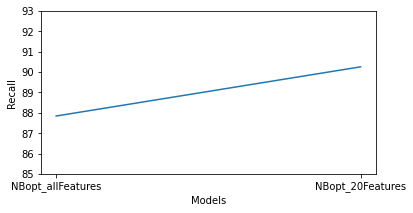

In [131]:
X_axis = ["NBopt_allFeatures", "NBopt_20Features"]
y_axis = NBmodels_cutFea.loc["recall"]
fix, ax = plt.subplots(figsize = (6, 3))
ax.plot(X_axis, y_axis)
ax.set_xlabel("Models")
ax.set_ylabel("Recall")

plt.ylim([85,93])

#### Insight:

It can be concluded that the recall improves by cutting 20% of the least important features.

# Do we need more data?

- We would like to see whether having more data could improve the prtedictability of our models or no.

- So, we are going to see what happens if we just have a proportion of observed data.

- By analyzing the trend of accuract, precision, and recall vs the number of training data, we can find if having more data could be helpful or not.

In [92]:
models_dataSize = make_comparision_df(index_lst = [], columns_lst = [])

In [93]:
analyze_data_size(keep_ratio = 0.5, X_train_original = X_train, X_test_original = X_test, y_train_original = y_train, y_test_original = y_test)
analyze_data_size(keep_ratio = 0.7, X_train_original = X_train, X_test_original = X_test, y_train_original = y_train, y_test_original = y_test)
analyze_data_size(keep_ratio = 0.9, X_train_original = X_train, X_test_original = X_test, y_train_original = y_train, y_test_original = y_test)
analyze_data_size(keep_ratio = 0.999, X_train_original = X_train, X_test_original = X_test, y_train_original = y_train, y_test_original = y_test)

Accuracy, Precision, Recall
Accuracy, Precision, Recall
Accuracy, Precision, Recall
Accuracy, Precision, Recall


In [94]:
models_dataSize

,50%,70%,90%,100%
accuracy,43.000000,43.577778,45.355556,46.044444
precision,26.595110,26.718938,27.252952,27.489790
recall,89.648241,89.045226,88.140704,87.939698


(40.0, 50.0)

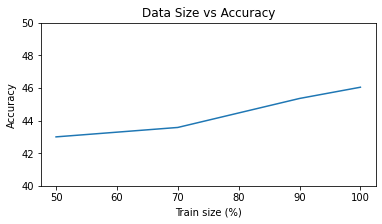

In [95]:
X_axis = [50, 70, 90, 100]
y_axis = models_dataSize.loc["accuracy"]
fix, ax = plt.subplots(figsize = (6, 3))
ax.plot(X_axis, y_axis)
ax.set_xlabel("Train size (%)")
ax.set_ylabel("Accuracy")
ax.set_title("Data Size vs Accuracy")
plt.ylim([40, 50])

#### Insight:
It can be concluded that the more the count of data, the improved the predictability.

## Inference time - Benchmark

Let's see  the inference time of the model using all features vs the model using top 20 features.

In [120]:
new_customer1 = OrderedDict([('limit_bal', 4000), ('age', 50), ('bill_amt1', 500),
                            ('bill_amt2', 35509), ('bill_amt3', 689), ('bill_amt4', 0),
                            ('bill_amt5',0), ('bill_amt6',0), ('pay_amt1', 0),('pay_amt2', 35509),
                            ('pay_amt3', 0), ('pay_amt4', 0),('pay_amt5',0), ('pay_amt6',0),
                            ('male', 1), ('married',1), ('grad_school', 0), ('university',1),
                            ('high_school',0), ('pay_0', -1),('pay_2', -1),
                            ('pay_3', -1), ('pay_4', 0),('pay_5',-1), ('pay_6',0)])
new_costomer1 = pd.Series(new_customer1)

In [121]:
new_customer2 = OrderedDict([('limit_bal', 4000), ('age', 50), ('bill_amt1', 500),
                            ('bill_amt2', 35509), ('bill_amt3', 689), ('bill_amt4', 0),
                            ('bill_amt5',0), ('bill_amt6',0), ('pay_amt1', 0),('pay_amt2', 35509),
                            ('pay_amt3', 0), ('pay_amt4', 0),('pay_amt5',0), ('pay_amt6',0),
                            ('male', 1), ('married',1), ('pay_0', -1),('pay_2', -1),('pay_3', -1),
                            ('pay_4', 0)])

new_costomer2 = pd.Series(new_customer2)

In [172]:
time1 = time.time()

for i in range(100000):
    make_predict(new_costomer1, model = NBoptallF, scaler = RS, threshold = 0.5)

time2 = time.time()       
duration_allF = time2 - time1
print(duration_allF)

24.49277377128601


In [171]:
time3 = time.time()

for i in range(100000):
    make_predict(new_costomer2, model = NBopt20F, scaler = RS2, threshold = 0.5)

time4 = time.time()       
duration_20F = time4 - time3
print(duration_20F)

20.829667568206787


In [177]:
time_cut = round(((duration_allF - duration_20F)/(duration_allF))*100)
print(time_cut,"% less time consuming")

15 % less time consuming


### Insight: 
We can conclude that cutting the least important features(20% of features) leads not only to improved predictability of the model (as shown in the previous part), but also to reduce the inference time by 15%. 

## Data pipeline

In [98]:
features_name = ["default", "high_school", "pay_6", "grad_school", "pay_5", "university"]
X3 = default.drop(features_name, axis = 1)
X_columns = X3.columns 
y3 = default["default"]
RS = RobustScaler()

In [101]:
steps = [('scaler', RobustScaler()), 
         ('model', GaussianNB(var_smoothing = 0.1873817422860384))]

finalModel = Pipeline(steps)
finalModel.fit(X3, y3);

### Saving the final pipeline

In [108]:
modelDirectory = os.path.join(os.path.dirname(os.getcwd()),'Jupyter\\Mae_CreditCard\\model')
fileName = modelDirectory + "\\model.sav"
pickle.dump(finalModel, open(fileName, 'wb'))

### Loading the final pipeline

In [180]:
loaded_model = pickle.load(open(modelDirectory + "\\model.sav", "rb"))

In [181]:
new_customer = OrderedDict([('limit_bal', 4000), ('age', 50), ('bill_amt1', 500),
                            ('bill_amt2', 35509), ('bill_amt3', 689), ('bill_amt4', 0),
                            ('bill_amt5',0), ('bill_amt6',0), ('pay_amt1', 0),('pay_amt2', 35509),
                            ('pay_amt3', 0), ('pay_amt4', 0),('pay_amt5',0), ('pay_amt6',0),
                            ('male', 1), ('married',1), ('pay_0', -1),('pay_2', -1),('pay_3', -1),
                            ('pay_4', 0)])

new_costomer = pd.Series(new_customer)
new_costomer= new_costomer.values.reshape(1, -1)

In [182]:
prob = loaded_model.predict_proba(new_costomer)[0, 1]

In [183]:
if prob >= 0.5:
    print("Will Default")
else:
    print("Will Pay")

Will Default
